# Degradation example with clearsky workflow


This juypter notebook is intended to illustrate the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

The degradation calculations consist of several steps illustrated here:
<ol start="0">
  <li><b>Import and preliminary calculations</b></li>
  <li><b>Normalize</b> data using a performance metric</li>
  <li><b>Filter</b> data that creates bias</li>
  <li><b>Aggregate data</b></li>
  <li> <b>Analyze</b> aggregated data to estimate the degradation rate</li>
</ol>

After demonstrating these steps using sensor data, a modified version of the workflow is illustrated using modled clear sky irradiance and temperature. The results from the two methods are compared

This notebook works with public data from the the Desert Knowledge Australia Solar Centre. Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

http://dkasolarcentre.com.au/historical-data/download

In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
%matplotlib inline

#The following is needed for timeseries plots with pandas v.0.21.0
from pandas.tseries import converter
converter.register()

#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

import rdtools
import pickle
import glob
import os
import re
import time

/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

# 0: Import and preliminary calculations


This section prepares the data necesary for an `rdtools` calculation. The first step of the `rdtools` workflow is normaliztion, which requires a time series of energy yield, a time series of cell temperature, and a time series of irradiance, along with some metadata (see Step 1: Normalize)

The following section loads the data, adjusts units where needed, and renames the critical columns. The irradiance sensor data source is transposed to plane-of-array, and the temperature sensor data source is converted into estimated cell temperature.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

<b>The steps of this section may change depending on your data source or the system being considered. Note that nothing in this first section utlizes the `rdtools` library.</b> Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are avaialble in [`pvlib`](https://github.com/pvlib/pvlib-python).

In [3]:
temp_model = 'roof_mount_cell_glassback'

#meta_path = os.path.join('/Users/anag/PV_reliability/pvoutput_weather', 'sys_meta.xlsx')
meta_path = os.path.join('/Volumes/shared/5J00/Staff/CDeline/pvoutput/Meta_Data', 'sys_meta.xlsx')
meta = pd.read_excel(meta_path)
meta.index = meta['ID']
surface_azimuth_map = {"N": 0, "S": 180, "E": 90,
                       "W": 270, "NW": 315, "SE": 135, "NE": 45, "SW": 225}
meta['Azimuth'] = meta['Orientation'].map(surface_azimuth_map)

#merged_glob = os.path.join('/Users/anag/PV_reliability/pvoutput_weather/merged_pickles', '*.gzip')
merged_glob = os.path.join('/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data',
                           'merged_pickles', '*.gzip')
print(merged_glob)
merged_files = glob.glob(merged_glob)
merged_sites = [int(re.search('\d{3,6}', x).group(0)) for x in merged_files]
merged_site_dict = dict(zip(merged_sites, merged_files))

/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/*.gzip


In [4]:
merged_files

['/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/10059_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/10284_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/10664_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/10807_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/10838_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/10858_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/10877_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1095_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/11019_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/11106_merged.gzip',
 '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickle

In [5]:
merged_sites

[10059,
 10284,
 10664,
 10807,
 10838,
 10858,
 10877,
 1095,
 11019,
 11106,
 11285,
 11329,
 11365,
 11526,
 11544,
 11839,
 12010,
 12043,
 12302,
 12417,
 12468,
 12535,
 12693,
 12949,
 12970,
 13092,
 13106,
 13521,
 13552,
 13640,
 13843,
 1384,
 13869,
 13951,
 13968,
 14064,
 14077,
 1421,
 14298,
 14320,
 14455,
 14564,
 14946,
 14992,
 14997,
 15001,
 15061,
 15080,
 15096,
 1519,
 1533,
 15386,
 15408,
 15596,
 15650,
 15932,
 16164,
 16470,
 16478,
 16642,
 16698,
 16846,
 16888,
 16908,
 16938,
 16947,
 16970,
 17024,
 17026,
 17152,
 17216,
 17248,
 1740,
 17857,
 18073,
 18167,
 18219,
 18410,
 18415,
 18613,
 1865,
 18731,
 18827,
 18905,
 18942,
 19005,
 19068,
 19098,
 19227,
 19275,
 19310,
 19411,
 19412,
 19618,
 19622,
 19623,
 19624,
 19806,
 20188,
 20215,
 20393,
 20423,
 20434,
 20447,
 20485,
 20553,
 20844,
 2088,
 20945,
 20954,
 20995,
 21167,
 21179,
 21197,
 21360,
 21403,
 21529,
 21580,
 21612,
 22194,
 2258,
 22900,
 23118,
 23162,
 23193,
 23263,
 

In [6]:
meta.head()

,ID,System Name,System Size(W),Postcode,Number Of Panels,Panel Power(W),Panel Brand,Number Of Inverters,Inverter Power(W),Inverter Brand,...,WS_1 Data %,WS_2 Data %,WS_3 Data %,WS_4 Data %,WS_5 Data %,Most Data WS,LastUpdate,Most Data WS Name,DB_ID,Azimuth
ID,,,,,,,,,,,,,,,,,,,,,
1095,1095,FewsFord,2160,27712,12,180,Day4,1,6000,Xantrex xw6048,...,29.88,6.04,10.88,38.66,27.69,WS_4,20170731,KNCHILLS11,1449,180.0
1384,1384,Eric's System,2760,55116,12,230,Siliken SLK60P6L,12,190,Enphase M190,...,6.32,24.66,5.16,11.57,24.93,WS_5,20170731,KMNSAINT89,1450,180.0
1421,1421,Bartfamily PV Array,3360,21009,16,210,Evergreen ES-A-210-fa2,1,3000,SMA Sunnyboy 3000US,...,39.44,62.11,82.63,14.55,12.97,WS_3,20170731,KMDEDGEW1,1451,180.0
1519,1519,Ohiobiker,9870,43138,42,235,NU-U235F1,42,250,Enphase Energy M250,...,4.62,3.83,39.81,29.63,10.04,WS_3,20170731,KOHLANCA11,1452,135.0
1533,1533,University Place WA Array,16660,98466,68,245,Sharp 175 & LG 270,68,210,Enphase,...,12.34,90.66,16.32,6.76,7.35,WS_2,20170731,KWAGIGHA12,1453,180.0


In [7]:
merged_site_dict

{1095: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1095_merged.gzip',
 1384: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1384_merged.gzip',
 1421: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1421_merged.gzip',
 1519: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1519_merged.gzip',
 1533: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1533_merged.gzip',
 1740: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1740_merged.gzip',
 1865: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/1865_merged.gzip',
 2088: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/2088_merged.gzip',
 2258: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/2258_merged.gzip',
 2912: '/Volumes/shared/5J00/Staff/CDeline/pvoutput/Merged_Data/merged_pickles/2912_merged.gzip',
 3152: '/Volumes/sha

In [8]:
f = merged_site_dict[1095]
site_meta = meta.loc[1095]

In [9]:
site_meta

ID                                   1095
System Name                      FewsFord
System Size(W)                       2160
Postcode                            27712
Number Of Panels                       12
Panel Power(W)                        180
Panel Brand                          Day4
Number Of Inverters                     1
Inverter Power(W)                    6000
Inverter Brand             Xantrex xw6048
Orientation                             S
Array Tilt(Degree)                     14
Shade                                 Low
Install Date                     20080301
Active Days                          1920
Latitude                          36.1067
Longitude                        -79.1455
Elevation(Ft)                      586.05
Status Interval(Mins)                   5
WS_1                            KNCEFLAN5
WS_2                           KNCHILLS19
WS_3                            KNCEFLAN1
WS_4                           KNCHILLS11
WS_5                           KNC

In [10]:
df = pd.read_pickle(f, compression='gzip')

In [11]:
df.head()

,SurfaceTemperatureCelsius,SurfaceDewpointTemperatureCelsius,SurfaceWetBulbTemperatureCelsius,RelativeHumidityPercent,SurfaceAirPressureKilopascals,CloudCoveragePercent,WindChillTemperatureCelsius,ApparentTemperatureCelsius,WindSpeedKph,WindDirectionDegrees,...,SnowfallCentimeters,SurfaceWindGustsKph,GlobalHorizontalIrradianceWsqm,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse,Power(W),Energy(Wh)
local_time,,,,,,,,,,,,,,,,,,,,,
2011-08-05 00:00:00-04:00,27.0,18.030001,20.7,58,99.5,6,27.0,27.9,12.6,87,...,0.0,24.0,0.0,0.0,-0.0,0.0,0.0,0.0,NaN,NaN
2011-08-05 01:00:00-04:00,26.5,18.610001,20.9,62,99.5,11,26.5,26.5,12.9,91,...,0.0,24.6,0.0,0.0,-0.0,0.0,0.0,0.0,NaN,NaN
2011-08-05 02:00:00-04:00,25.9,19.430000,21.3,67,99.6,28,25.9,25.9,12.7,92,...,0.0,24.3,0.0,0.0,-0.0,0.0,0.0,0.0,NaN,NaN
2011-08-05 03:00:00-04:00,24.8,19.610001,21.1,73,99.7,36,24.8,24.8,10.3,78,...,0.0,20.9,0.0,0.0,-0.0,0.0,0.0,0.0,NaN,NaN
2011-08-05 04:00:00-04:00,24.2,20.120001,21.2,78,99.6,31,24.2,24.2,11.6,75,...,0.0,22.4,0.0,0.0,-0.0,0.0,0.0,0.0,NaN,NaN


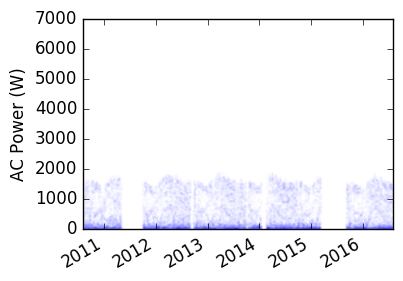

In [12]:
# Calculate the hour by hour energy from daily cumulative
df['date'] = df.index.date
days = df.groupby('date')

group_list = []
for ix, day in days:
    daily_diff = day['Energy(Wh)'].fillna(0).diff()
    daily_diff[daily_diff < 0] = 0
    daily_diff = daily_diff.fillna(0)
    group_list.append(daily_diff)

df['hourly_energy(Wh)'] = pd.concat(group_list)

# Calculate cell temperature
df_temp = pvlib.pvsystem.sapm_celltemp(df['poa_global'], df['WindSpeedKph']*1000.0/3600.0, df['SurfaceTemperatureCelsius'], model=temp_model)
df['Tcell'] = df_temp['temp_cell']

# plot the AC power time series
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df['Power(W)'], 'o', alpha = 0.01)
ax.set_ylim(0,7000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

In [13]:
print(df.index.freq)

<Hour>


# 1: Normalize

Data normalization is achieved with `rdtools.normalize_with_pvwatts()`. We provide a time sereis of energy, along with keywords used to run a pvwatts model of the system. More information available in the docstring.

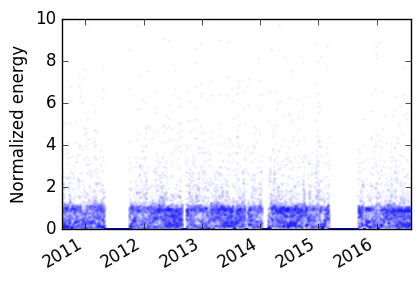

In [14]:
# Specify the keywords for the pvwatts model
pvwatts_kws = {"poa_global" : df['poa_global'],
              "P_ref" : site_meta['System Size(W)'],
              "T_cell" : df['Tcell'],
              "G_ref" : 1000.0,
              "T_ref": 25.0,
              "gamma_pdc" : -0.0045}

# Calculate the normalization, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
normalized, insolation = rdtools.normalize_with_pvwatts(df['hourly_energy(Wh)'], pvwatts_kws)

df['normalized'] = normalized
df['insolation'] = insolation

# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,10)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

# 2: Filter

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.

It can also be useful to remove outages and outliers. Sometimes outages appear as low but non-zero yield. Automatic functions for this are not yet included in `rdtools`. Such filters should be implimented by the analyst if needed.

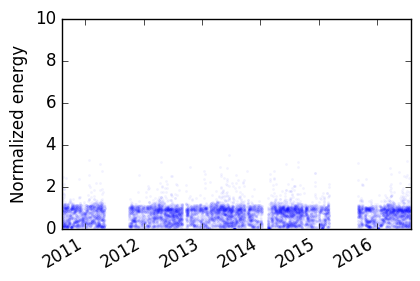

In [15]:
# Calculate a collection of boolean masks that can be used
# to filter the time series
nz_mask = (df['normalized'] > 0)
poa_mask = rdtools.poa_filter(df['poa_global'])
tcell_mask = rdtools.tcell_filter(df['Tcell'])

#clip_mask = rdtools.clip_filter(df['Power(W)'])
# clip mask is likely no good on hourly data from roof mount PV systems.

# filter the time series and keep only the columns needed for the
# remaining steps
#filtered = df[nz_mask & poa_mask & tcell_mask & clip_mask]
filtered = df[nz_mask & poa_mask & tcell_mask]
filtered = filtered[['insolation', 'normalized']]

fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,10)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

# 3: Aggregate

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

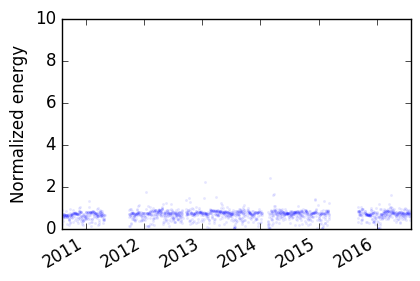

In [16]:
daily = rdtools.aggregation_insol(filtered['normalized'], filtered['insolation'], frequency='D')

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,10)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

# 4: Degradation calculation

Data is then analyzed to estimate the degradation rate representing the PV system behavior. The results are visualized and statistics are reported, including the 68.2% confidence interval, and the P95 exceedence value.

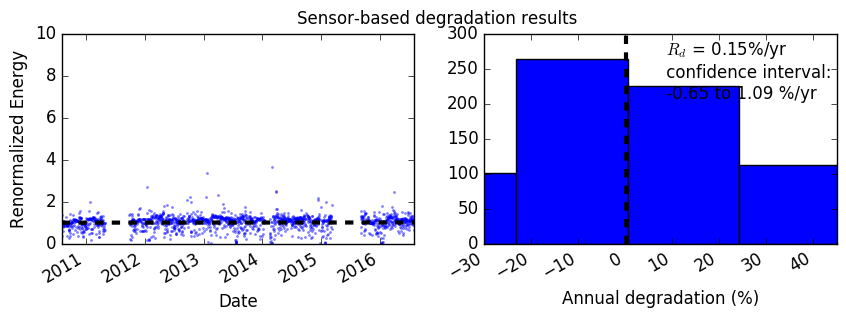

In [17]:
# Calculate the degradation rate using the YoY method
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily)


# Visualize the results
start = daily.index[0]
end = daily.index[-1]
years = (end - start).days / 365.0
yoy_values = yoy_info['YoY_values']

x = [start, end]
y = [1, 1 + (yoy_rd * years)/100]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax2.hist(yoy_values, label='YOY', bins=len(yoy_values)/40)
ax2.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(yoy_rd, yoy_ci[0], yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');

ax1.plot(daily.index, daily/yoy_info['renormalizing_factor'], 'o', alpha = 0.5)
ax1.plot(x, y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0,10)
fig.autofmt_xdate()

fig.suptitle('Sensor-based degradation results');

In addition to the confidence interval, the year-on-year method yields an exceedence value (e.g. P95), the degradation rate that was exceeded (slower degradation) with a given probability level. The probability level is set via the `exceedence_prob` keyword in `degradation_year_on_year`.

In [18]:
print 'The P95 exceedance level is %.2f%%/yr' % yoy_info['exceedance_level']

The P95 exceedance level is -1.10%/yr


# Clear sky workflow
The clear sky workflow is useful in that it avoids problems due to drift or recalibration of ground-based sensors. We use `pvlib` to model the clear sky irradiance. This is renormalized to align it with ground-based measurements. Finally we use `rdtools.get_clearsky_tamb()` to model the ambient temperature on clear sky days. This modeled ambient temperature is used to model cell temperature with `pvlib`. If high quality amabient temperature data is available, that can be used instead of the modeled ambient; we proceed with the modeled ambient temperature here for illustrative purposes.

In this example, note that we have omitted wind data in the cell temperature calculations for illustrative purposes. Wind data can also be included when the data source is trusted for improved results

**Note that the claculations below rely on some objects from the steps above**

# Clear Sky 0: Preliminary Calculations

In [19]:
df.index

DatetimeIndex(['2011-08-05 00:00:00-04:00', '2011-08-05 01:00:00-04:00',
               '2011-08-05 02:00:00-04:00', '2011-08-05 03:00:00-04:00',
               '2011-08-05 04:00:00-04:00', '2011-08-05 05:00:00-04:00',
               '2011-08-05 06:00:00-04:00', '2011-08-05 07:00:00-04:00',
               '2011-08-05 08:00:00-04:00', '2011-08-05 09:00:00-04:00',
               ...
               '2017-07-30 14:00:00-04:00', '2017-07-30 15:00:00-04:00',
               '2017-07-30 16:00:00-04:00', '2017-07-30 17:00:00-04:00',
               '2017-07-30 18:00:00-04:00', '2017-07-30 19:00:00-04:00',
               '2017-07-30 20:00:00-04:00', '2017-07-30 21:00:00-04:00',
               '2017-07-30 22:00:00-04:00', '2017-07-30 23:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name=u'local_time', length=52488, freq='H')

In [20]:
df.head(n=50)

,SurfaceTemperatureCelsius,SurfaceDewpointTemperatureCelsius,SurfaceWetBulbTemperatureCelsius,RelativeHumidityPercent,SurfaceAirPressureKilopascals,CloudCoveragePercent,WindChillTemperatureCelsius,ApparentTemperatureCelsius,WindSpeedKph,WindDirectionDegrees,...,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse,Power(W),Energy(Wh),date,hourly_energy(Wh),Tcell,normalized,insolation
local_time,,,,,,,,,,,,,,,,,,,,,
2011-08-05 00:00:00-04:00,27.0,18.030001,20.7,58,99.5,6,27.0,27.9,12.6,87,...,0.000000,0.000000,0.000000,NaN,NaN,2011-08-05,0.0,27.000000,NaN,0.000000
2011-08-05 01:00:00-04:00,26.5,18.610001,20.9,62,99.5,11,26.5,26.5,12.9,91,...,0.000000,0.000000,0.000000,NaN,NaN,2011-08-05,0.0,26.500000,NaN,0.000000
2011-08-05 02:00:00-04:00,25.9,19.430000,21.3,67,99.6,28,25.9,25.9,12.7,92,...,0.000000,0.000000,0.000000,NaN,NaN,2011-08-05,0.0,25.900000,NaN,0.000000
2011-08-05 03:00:00-04:00,24.8,19.610001,21.1,73,99.7,36,24.8,24.8,10.3,78,...,0.000000,0.000000,0.000000,NaN,NaN,2011-08-05,0.0,24.800000,NaN,0.000000
2011-08-05 04:00:00-04:00,24.2,20.120001,21.2,78,99.6,31,24.2,24.2,11.6,75,...,0.000000,0.000000,0.000000,NaN,NaN,2011-08-05,0.0,24.200000,NaN,0.000000
2011-08-05 05:00:00-04:00,23.3,20.370001,21.2,84,99.6,20,23.3,23.3,11.8,75,...,0.000000,0.000000,0.000000,NaN,NaN,2011-08-05,0.0,23.300000,NaN,0.000000
2011-08-05 06:00:00-04:00,22.7,20.600000,21.1,88,99.7,21,22.7,22.7,10.9,71,...,0.000000,0.000000,0.000000,NaN,NaN,2011-08-05,0.0,22.700000,NaN,0.000000
2011-08-05 07:00:00-04:00,22.6,20.730000,21.3,89,99.8,22,22.6,22.6,10.9,69,...,27.673507,27.460759,0.212747,1.000000,0.0,2011-08-05,0.0,24.133015,0.000000,34.035122
2011-08-05 08:00:00-04:00,24.0,20.969999,21.8,83,99.8,31,24.0,24.0,11.5,73,...,71.818611,70.925957,0.892654,21.666667,20.0,2011-08-05,20.0,33.651601,0.044618,215.930280


In [21]:
# Calculate the clear sky POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(site_meta['Latitude'], site_meta['Longitude'], tz = str(df.index.tz))
sun = loc.get_solarposition(df.index)
clearsky = loc.get_clearsky(df.index, solar_position = sun)

# Calculate the poa_irradiance
dni_extra = pvlib.irradiance.extraradiation(df.index)
am = loc.get_airmass(solar_position=sun)['airmass_relative']

perez_clearsky = pvlib.irradiance.total_irrad(site_meta['Array Tilt(Degree)'], site_meta['Azimuth'],
                                                  sun['apparent_zenith'], sun['azimuth'], clearsky['dni'],
                                                  clearsky['ghi'], clearsky['dhi'],
                                                  dni_extra=dni_extra, airmass=am, model='perez')

df['clearsky_poa'] = perez_clearsky['poa_global']

# Calculate the clearsky temperature
df['clearsky_Tamb'] = rdtools.get_clearsky_tamb(df.index, site_meta['Latitude'], site_meta['Longitude'])
df_clearsky_temp = pvlib.pvsystem.sapm_celltemp(df['clearsky_poa'], 0, df['clearsky_Tamb'], model=temp_model)
df['clearsky_Tcell'] = df_clearsky_temp.temp_cell

/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/pvlib/irradiance.py:1002: RuntimeWarning: invalid value encountered in less
  ebin[eps < 1.065] = 1
/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/pvlib/irradiance.py:1003: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/pvlib/irradiance.py:1003: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/pvlib/irradiance.py:1004: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/pvlib/irradiance.py:1004: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/pvlib/irradiance.py:1005: Runt

# Clear Sky 1: Normalize
Normalize as in step 1 above, but this time using clearsky modeled irradiance and cell temperature

In [22]:
# Update the PVWatts key words with clearsky conditions
pvwatts_kws['poa_global'] = df['clearsky_poa']
pvwatts_kws['T_cell'] = df['clearsky_Tcell']

clearsky_normalized, clearsky_insolation = rdtools.normalize_with_pvwatts(df['hourly_energy(Wh)'], pvwatts_kws)

df['clearsky_normalized'] = clearsky_normalized
df['clearsky_insolation'] = clearsky_insolation

# Clear Sky 2: Filter
Filter as in step 2 above, but with the addition of a clear sky index (csi) filter so we consider only points well modeled by the clear sky irradiance model.

In [23]:
# Perform clearsky filter
cs_nz_mask = (df['clearsky_normalized'] > 0)
cs_poa_mask = rdtools.poa_filter(df['clearsky_poa'])
cs_tcell_mask = rdtools.tcell_filter(df['clearsky_Tcell'])

csi_mask = rdtools.csi_filter(df.insolation, df.clearsky_insolation)

clearsky_filtered = df[cs_nz_mask & cs_poa_mask & cs_tcell_mask & csi_mask]
clearsky_filtered = clearsky_filtered[['clearsky_insolation', 'clearsky_normalized']]

# Clear Sky 3: Aggregate
Aggregate the clear sky version of of the filtered data 

In [24]:
clearsky_daily = rdtools.aggregation_insol(clearsky_filtered['clearsky_normalized'], clearsky_filtered['clearsky_insolation'])

# Clear Sky 4: Degradation Calculation
Estimate the degradation rate and compare to the results obtained with sensors. In this case, we see that irradiance sensor drift may have biased the sensor-based results, a problem that is corrected by the clear sky approach.

In [25]:
# Calculate the degradation rate using the YoY method
cs_yoy_rd, cs_yoy_ci, cs_yoy_info = rdtools.degradation_year_on_year(clearsky_daily)

output = {
        'Rd': yoy_rd,
        'Rd_CI': yoy_ci,
        'clearsky_Rd': cs_yoy_rd,
        'clearsky_Rd_CI': cs_yoy_ci,
        'dataframe': df,
        'daily': daily,
        'clearsky_daily': clearsky_daily,
        'timespan': df.index[-1] - df.index[0]
    }

In [26]:
output

{'Rd': 0.1516194438254007,
 'Rd_CI': array([-0.6518767 ,  1.08659503]),
 'clearsky_Rd': -0.31666060851336386,
 'clearsky_Rd_CI': array([-1.59257576,  1.11149863]),
 'clearsky_daily': local_time
 2011-08-05 00:00:00-04:00    0.248288
 2011-08-06 00:00:00-04:00    0.873180
 2011-08-07 00:00:00-04:00    0.606183
 2011-08-08 00:00:00-04:00    0.703157
 2011-08-09 00:00:00-04:00    0.745381
 2011-08-10 00:00:00-04:00    0.652807
 2011-08-11 00:00:00-04:00    0.637624
 2011-08-12 00:00:00-04:00    0.799551
 2011-08-13 00:00:00-04:00    0.384237
 2011-08-14 00:00:00-04:00    0.569319
 2011-08-15 00:00:00-04:00    0.495633
 2011-08-16 00:00:00-04:00    0.748129
 2011-08-17 00:00:00-04:00    0.681724
 2011-08-18 00:00:00-04:00    0.412791
 2011-08-19 00:00:00-04:00    0.653867
 2011-08-20 00:00:00-04:00    0.713373
 2011-08-21 00:00:00-04:00    0.473373
 2011-08-22 00:00:00-04:00    0.608795
 2011-08-23 00:00:00-04:00    0.744399
 2011-08-24 00:00:00-04:00    0.622731
 2011-08-25 00:00:00-04:00

The P95 exceedance level with the clear sky analysis is -2.24%/yr


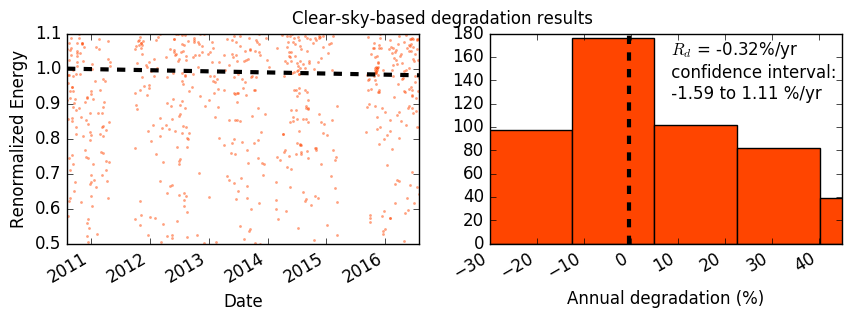

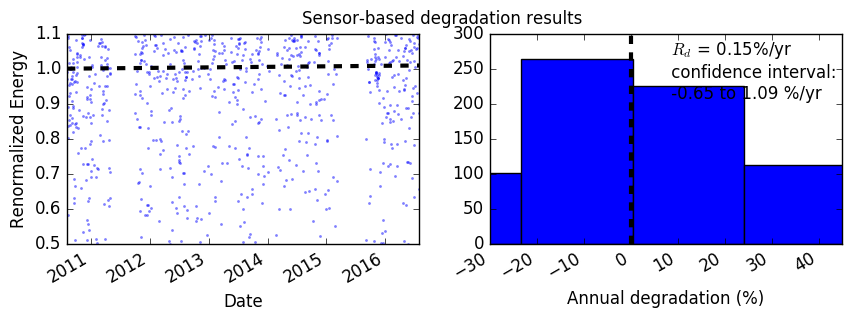

In [27]:
# Visualize the results
cs_start = clearsky_daily.index[0]
cs_end = clearsky_daily.index[-1]
cs_years = (cs_end - cs_start).days / 365.0
cs_yoy_values = cs_yoy_info['YoY_values']

cs_x = [cs_start, cs_end]
cs_y = [1, 1 + (cs_yoy_rd * cs_years)/100]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax2.hist(cs_yoy_values, label='YOY', bins=len(cs_yoy_values)/40, color = 'orangered')
ax2.axvline(x=cs_yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(cs_yoy_rd, cs_yoy_ci[0], cs_yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');

ax1.plot(clearsky_daily.index, clearsky_daily/cs_yoy_info['renormalizing_factor'], 'o', color = 'orangered', alpha = 0.5)
ax1.plot(cs_x, cs_y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()

fig.suptitle('Clear-sky-based degradation results');



# repeat the plots from above
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax2.hist(yoy_values, label='YOY', bins=len(yoy_values)/40)
ax2.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(yoy_rd, yoy_ci[0], yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');

ax1.plot(daily.index, daily/yoy_info['renormalizing_factor'], 'o', alpha = 0.5)
ax1.plot(x, y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()

fig.suptitle('Sensor-based degradation results');

print 'The P95 exceedance level with the clear sky analysis is %.2f%%/yr' % cs_yoy_info['exceedance_level']